# Alexandre AUTRET, DIA1, Python for Data Analysis

### Unmanned Aerial Vehicle (UAV) Intrusion Detection Data Set

_Liang Zhao, Amir Alipour-Fanid, Martin Slawski and Kai Zeng. Prediction-time Efficient Classification Using Feature Computational Dependencies. In Proceedings of the 24st ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD 2018), research track (acceptance rate: 18.4%), London, United Kingdom, Aug 2018, Pages 2787-2796._

The goal of this project is to build a model that predicts whether a UAV has been hijacked or not.

### Exploring our dataset

Let's import the necessary libraries:

In [1]:
%matplotlib inline
from h5py import File #needed to read our data set, which is an HDF5 mat file
import numpy as np
import pandas as pd

Let's read our data and store it as a pandas DataFrame:

In [2]:
data_dict = {}
with File("pub_dataset1.mat", "r") as file_dict:
    cols = ["col{}".format(i) for i in range(len(file_dict["data_tr"]))]
    vals = np.array([[val for val in col] for col in file_dict["data_tr"]]) #returns the transpose of the data matrix we want
    data = pd.DataFrame(vals.T, columns=cols) #so we transpose it here

To make the data more readable, let's rename the columns to what they represent (information available on the website):

In [3]:
new_cols = ["uplink_size_mean", "uplink_size_median", "uplink_size_MAD", "uplink_size_STD", "uplink_size_Skewness",
            "uplink_size_Kurtosis", "uplink_size_MAX", "uplink_size_MIN", "uplink_size_MeanSquare", "downlink_size_mean",
            "downlink_size_median", "downlink_size_MAD", "downlink_size_STD", "downlink_size_Skewness", "downlink_size_Kurtosis",
            "downlink_size_MAX", "downlink_size_MIN", "downlink_size_MeanSquare", "both_links_size_mean", "both_links_size_median",
            "both_links_size_MAD", "both_links_size_STD", "both_links_size_Skewness", "both_links_size_Kurtosis", "both_links_size_MAX",
            "both_links_size_MIN", "both_links_size_MeanSquare", "uplink_interval_mean", "uplink_interval_median", "uplink_interval_MAD",
            "uplink_interval_STD", "uplink_interval_Skewness", "uplink_interval_Kurtosis", "uplink_interval_MAX", "uplink_interval_MIN",
            "uplink_interval_MeanSquare", "downlink_interval_mean", "downlink_interval_median", "downlink_interval_MAD", "downlink_interval_STD",
            "downlink_interval_Skewness", "downlink_interval_Kurtosis", "downlink_interval_MAX", "downlink_interval_MIN", "downlink_interval_MeanSquare", 
            "both_links_interval_mean", "both_links_interval_median", "both_links_interval_MAD", "both_links_interval_STD", "both_links_interval_Skewness",
            "both_links_interval_Kurtosis", "both_links_interval_MAX", "both_links_interval_MIN", "both_links_interval_MeanSquare", "label"]
data.columns = new_cols

Let's get some information about this DataFrame:

In [4]:
print("This data set has {0} rows and {1} columns:\n".format(*data.shape))
data.head()

This data set has 1751 rows and 55 columns:



,uplink_size_mean,uplink_size_median,uplink_size_MAD,uplink_size_STD,uplink_size_Skewness,uplink_size_Kurtosis,uplink_size_MAX,uplink_size_MIN,uplink_size_MeanSquare,downlink_size_mean,downlink_size_median,downlink_size_MAD,downlink_size_STD,downlink_size_Skewness,downlink_size_Kurtosis,downlink_size_MAX,downlink_size_MIN,downlink_size_MeanSquare,both_links_size_mean,both_links_size_median,both_links_size_MAD,both_links_size_STD,both_links_size_Skewness,both_links_size_Kurtosis,both_links_size_MAX,both_links_size_MIN,both_links_size_MeanSquare,uplink_interval_mean,uplink_interval_median,uplink_interval_MAD,uplink_interval_STD,uplink_interval_Skewness,uplink_interval_Kurtosis,uplink_interval_MAX,uplink_interval_MIN,uplink_interval_MeanSquare,downlink_interval_mean,downlink_interval_median,downlink_interval_MAD,downlink_interval_STD,downlink_interval_Skewness,downlink_interval_Kurtosis,downlink_interval_MAX,downlink_interval_MIN,downlink_interval_MeanSquare,both_links_interval_mean,both_links_interval_median,both_links_interval_MAD,both_links_interval_STD,both_links_interval_Skewness,both_links_interval_Kurtosis,both_links_interval_MAX,both_links_interval_MIN,both_links_interval_MeanSquare,label
0,0.013633,0.009907,0.012473,0.013195,0.206939,-1.518004,0.029022,0.000002,0.016793,113.612245,32.643157,138.0,17.7912,-0.524785,-1.621986,153.0,70.0,118.116770,0.013402,0.009805,0.012023,0.012642,0.254736,-1.480650,0.029021,0.000408,0.016549,136.078431,205.772966,70.0,0.0000,4.398569,18.352606,1130.0,70.0,245.009404,0.006835,0.009674,0.000241,0.000351,1.164627,-0.178463,0.028997,0.000002,0.011805,125.07,148.422224,126.0,83.0256,6.183629,39.041176,1130.0,70.0,193.523564,1.0
1,0.176876,0.328222,0.050990,0.072377,2.746796,7.799352,1.629773,0.000309,0.369391,487.000000,392.264657,395.5,255.7485,1.692933,1.546272,1476.0,222.0,622.396138,0.128085,0.254164,0.029409,0.043299,3.309583,12.659707,1.482584,0.000143,0.282651,308.827586,214.947496,264.0,63.7518,3.713849,12.835863,1293.0,216.0,375.207023,0.074292,0.198067,0.001850,0.002549,4.688625,25.950990,1.478154,0.000117,0.210612,383.66,313.268698,307.0,126.0210,2.542834,5.425483,1476.0,216.0,494.318622,0.0
2,0.003496,0.004608,0.001605,0.001622,1.884811,2.649103,0.018668,0.000177,0.005718,96.857143,22.093596,88.0,0.0000,1.932871,1.804209,150.0,88.0,99.257242,0.001428,0.003718,0.000158,0.000228,3.658123,13.575117,0.020585,0.000001,0.003959,588.986111,413.681973,741.5,457.3821,-0.272712,-1.735861,1108.0,76.0,718.095098,0.001042,0.002882,0.000025,0.000035,4.084852,17.829972,0.018668,0.000001,0.003051,451.19,414.950105,150.0,109.7124,0.358598,-1.731709,1108.0,76.0,611.583330,1.0
3,0.004229,0.005576,0.000986,0.001195,1.088090,-0.287253,0.018410,0.000009,0.006926,98.225806,28.208403,88.0,0.0000,2.800722,8.100519,218.0,76.0,102.070343,0.001919,0.005633,0.000105,0.000153,3.661035,13.732723,0.032340,0.000001,0.005912,599.434783,376.788148,770.0,240.1812,-0.435652,-1.484070,1094.0,76.0,706.564817,0.001324,0.003575,0.000067,0.000096,3.100149,8.892516,0.018410,0.000001,0.003795,444.06,389.912910,147.0,105.2646,0.311359,-1.699683,1094.0,76.0,589.661801,1.0
4,0.003080,0.005691,0.000934,0.000975,2.881301,8.274496,0.026786,0.000011,0.006387,96.533333,27.042410,88.0,0.0000,3.245917,10.956115,218.0,76.0,100.127918,0.001326,0.004443,0.000034,0.000040,4.790659,24.285991,0.029226,0.000007,0.004606,649.371429,376.682782,794.0,235.7334,-0.564116,-1.208588,1218.0,76.0,749.363844,0.000933,0.003334,0.000029,0.000031,5.731184,36.394334,0.026335,0.000007,0.003446,483.52,404.892316,417.0,505.5666,0.198671,-1.704260,1218.0,76.0,629.356815,1.0


Let's visualize how each variable looks with regards to our target variable:

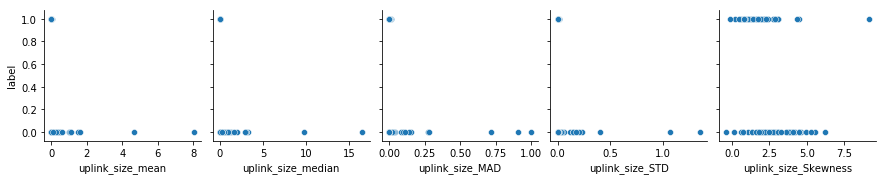

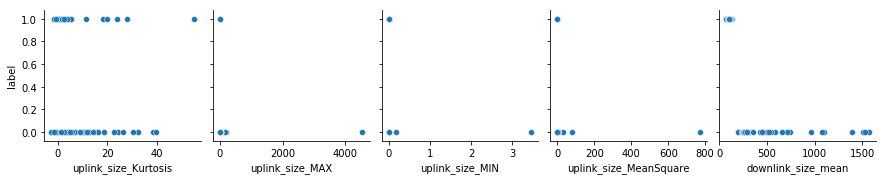

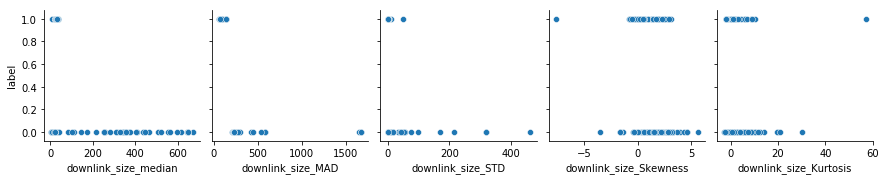

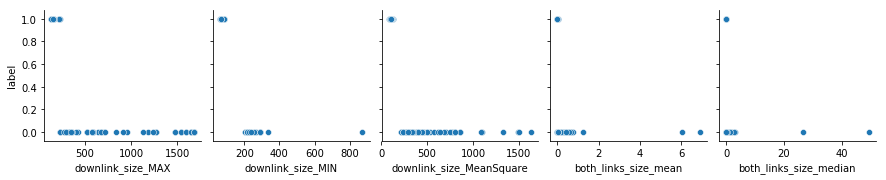

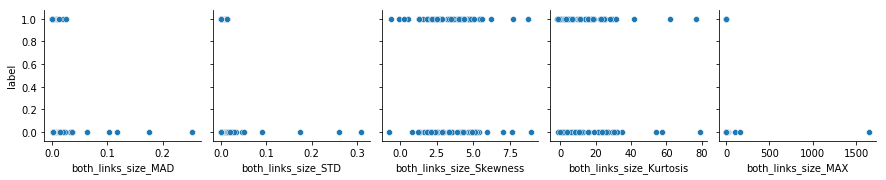

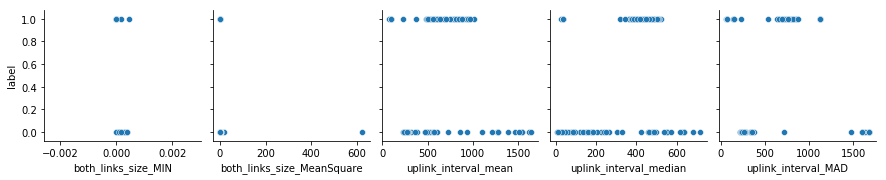

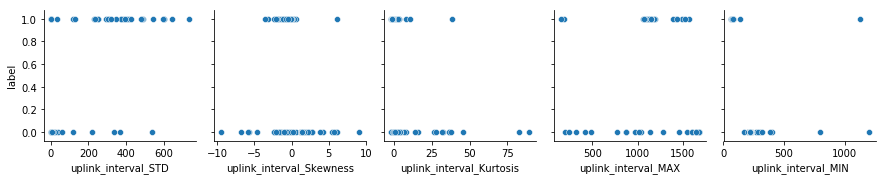

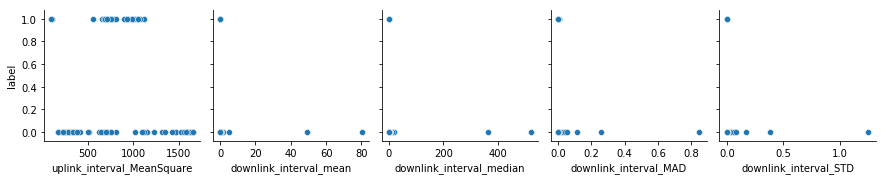

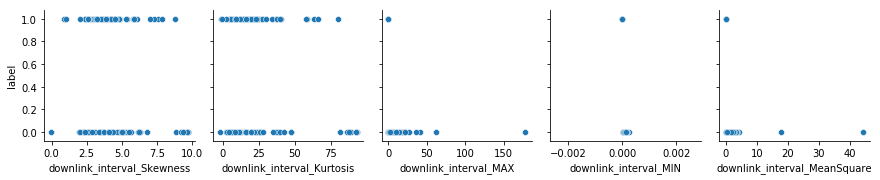

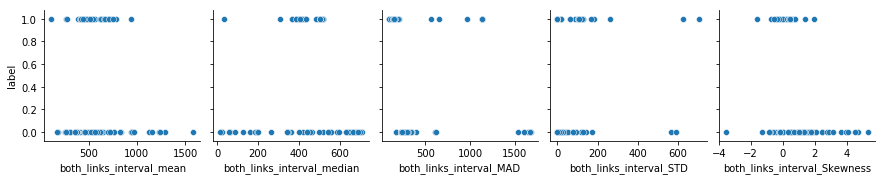

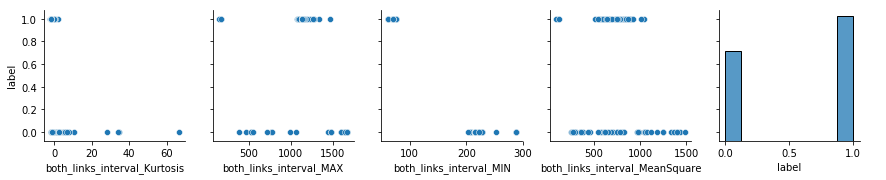

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb
for i in range(11):
    sb.pairplot(data=data.sample(100), y_vars=["label"], x_vars=data.iloc[:, 5*i:5*i+5])
    plt.show()

From what we can gather here, uplink and downlink communication with a hijacked UAV is always close to null.
Most parameters seem relevant to some degree, except uplink_size_MIN, both_links_size_Skewness and both_links_size_Kurtosis.

### Predictive modeling

We want to first train a simple logistic regression, since it seems like it would fit our dataset extremely well: we can expect a sigmoid that drops sharply (almost vertically).

Let's split our dataset into training (75%) and testing (25%):

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.drop("label", axis=1), data["label"], test_size=0.25)

In [7]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(max_iter=10000, solver="lbfgs")
lm.fit(x_train, y_train)
predictions = lm.predict(x_test)

Let's plot the logistic function for a few variables, to get an idea of how it looks:

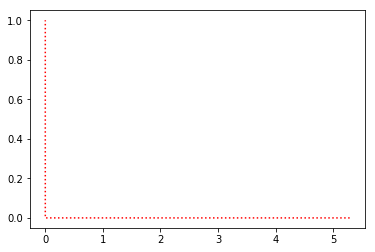

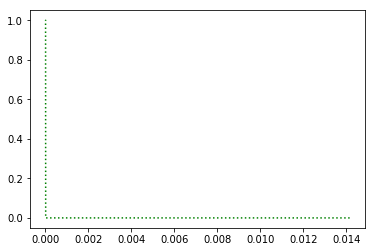

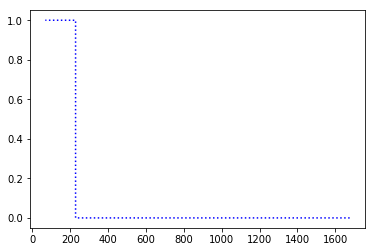

In [8]:
plt.plot(sorted(x_test["uplink_size_MIN"], reverse=True), sorted(lm.predict_proba(x_test)[:,1]), color="red", linestyle=":")
plt.show()
plt.plot(sorted(x_test["both_links_size_MIN"], reverse=True), sorted(lm.predict_proba(x_test)[:,1]), color="green", linestyle=":")
plt.show()
plt.plot(sorted(x_test["downlink_size_MAX"], reverse=True), sorted(lm.predict_proba(x_test)[:,1]), "blue", linestyle=":")
plt.show()

As expected, we get sigmoids that drop sharply.

Let's compute our model's accuracy:

In [9]:
from sklearn.metrics import classification_report
lbls = ["NOT hijacked (0)", "hijacked (1)"]
print(classification_report(y_test, predictions, target_names=lbls))

                  precision    recall  f1-score   support

NOT hijacked (0)       1.00      1.00      1.00       200
    hijacked (1)       1.00      1.00      1.00       238

       micro avg       1.00      1.00      1.00       438
       macro avg       1.00      1.00      1.00       438
    weighted avg       1.00      1.00      1.00       438



__We notice that our model has an accuracy and recall of 1, therefore we don't really need a more complex one.__

For the sake of not just having our logistic model, let's also try a random forest model and see how it performs.

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_test)
for i in range(len(rf_preds)):
    if rf_preds[i] < 0.5:
        rf_preds[i] = 0.0
    else:
        rf_preds[i] = 1.0
print(classification_report(y_test, rf_preds, target_names=lbls))

                  precision    recall  f1-score   support

NOT hijacked (0)       1.00      1.00      1.00       200
    hijacked (1)       1.00      1.00      1.00       238

       micro avg       1.00      1.00      1.00       438
       macro avg       1.00      1.00      1.00       438
    weighted avg       1.00      1.00      1.00       438



This model is very accurate as well, so we don't need to fiddle with any hyperparameter to make it work.